In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load dataset files
tracks = pd.read_csv("tracks.csv", header=[0, 1], low_memory=False)
features = pd.read_csv("features.csv", header=[0, 1], low_memory=False)
genres = pd.read_csv("genres.csv")

In [3]:
# Flatten the multi-level column names
features.columns = [f"{col[0]}_{col[1]}" for col in features.columns]

# Move index to a column so we can merge later
features = features.reset_index()
features = features.rename(columns={"index": "track_id"})

features_df = features.copy()

In [4]:
# Extract top-level genre
track_genres = tracks[[("track", "genre_top")]].copy()
track_genres.columns = ["genre"]

# Move index to column
track_genres = track_genres.reset_index()
track_genres = track_genres.rename(columns={"index": "track_id"})

In [5]:
# Merge using track_id
data = pd.merge(
    features_df,
    track_genres,
    on="track_id",
    how="inner"
)


In [6]:
data = data.dropna(subset=["genre"])


In [7]:
# Input features
X = data.drop(columns=["track_id", "genre"])

# Target labels
y = data["genre"]

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
# Remove non-numeric columns if any exist
X = X.select_dtypes(include=[np.number])

In [10]:
# Replace infinite values with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Fill missing values with column mean
X = X.fillna(X.mean())


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

knn_accuracy = accuracy_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred, average="macro")
knn_recall = recall_score(y_test, knn_pred, average="macro")
knn_f1 = f1_score(y_test, knn_pred, average="macro")

In [14]:
svm = SVC(kernel="rbf", C=10)
svm.fit(X_train_scaled, y_train)

svm_pred = svm.predict(X_test_scaled)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_precision = precision_score(y_test, svm_pred, average="macro")
svm_recall = recall_score(y_test, svm_pred, average="macro")
svm_f1 = f1_score(y_test, svm_pred, average="macro")

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, average="macro")
rf_recall = recall_score(y_test, rf_pred, average="macro")
rf_f1 = f1_score(y_test, rf_pred, average="macro")

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
results = pd.DataFrame({
    "Algorithm": ["KNN", "SVM", "Random Forest"],
    "Accuracy": [knn_accuracy, svm_accuracy, rf_accuracy],
    "Precision": [knn_precision, svm_precision, rf_precision],
    "Recall": [knn_recall, svm_recall, rf_recall],
    "F1 Score": [knn_f1, svm_f1, rf_f1]
})

results

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,KNN,0.534677,0.443600,0.378500,0.381556
1,SVM,0.616028,0.644636,0.419433,0.471915
2,Random Forest,0.568750,0.586241,0.296255,0.320333


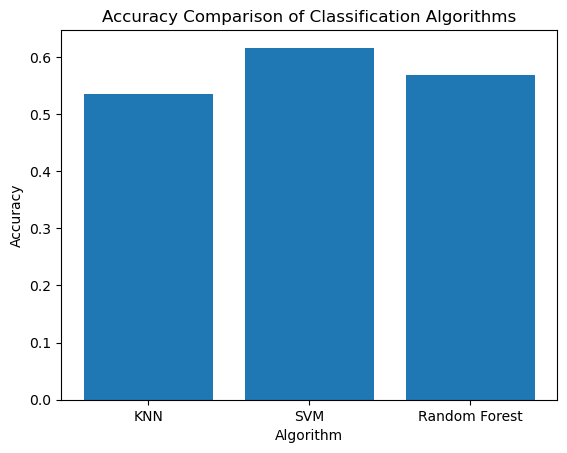

In [17]:
import matplotlib.pyplot as plt

models = ["KNN", "SVM", "Random Forest"]
accuracy_scores = [knn_accuracy, svm_accuracy, rf_accuracy]

plt.figure()
plt.bar(models, accuracy_scores)
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Classification Algorithms")
plt.show()

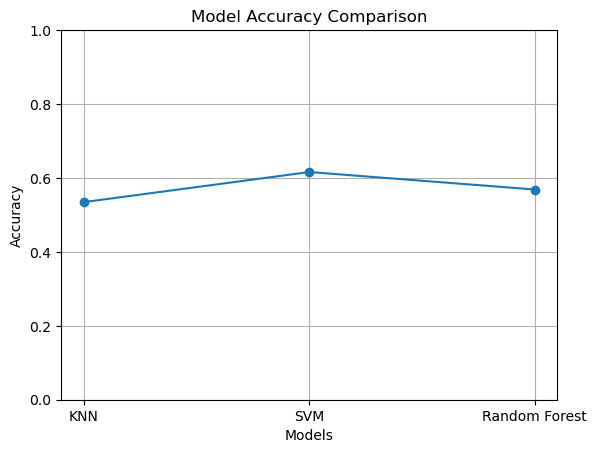

In [37]:
plt.figure()
plt.plot(models, accuracy_scores, marker='o')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

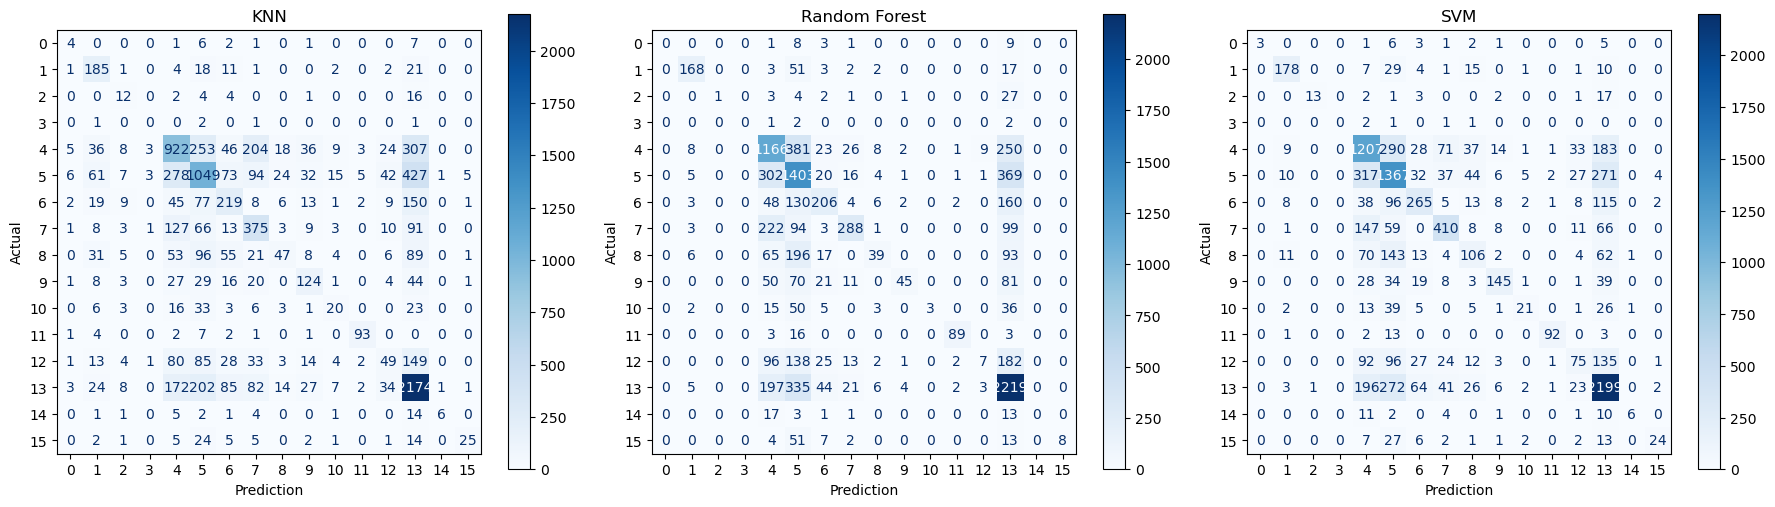

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = np.unique(y_test)

models = {
    "KNN": knn_pred,
    "Random Forest": rf_pred,
    "SVM": svm_pred
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, preds) in zip(axes, models.items()):
    cm = confusion_matrix(
        y_test,
        preds,
        labels=class_labels
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_labels
    )

    disp.plot(
        ax=ax,
        cmap="Blues",        
        colorbar=True,       
        values_format="d"    
    )

    ax.set_title(name)
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    ax.tick_params(axis="x", rotation=0)
    ax.tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()